<a href="https://colab.research.google.com/github/SaiSriramKamineni/-Invsto/blob/main/Arima_and_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime

In [ ]:
# Load dataset
df = pd.read_csv('stock_data.csv', parse_dates=['Date'], index_col='Date')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


In [ ]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [ ]:
df.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA
2017-12-29,69.79,70.13,69.43,69.85,6613070,AABA


In [ ]:
# Data Cleaning
df = df.dropna()
df = df[df['Close'] > 0]

In [ ]:
df.dtypes

,0
Open,float64
High,float64
Low,float64
Close,float64
Volume,int64
Name,object


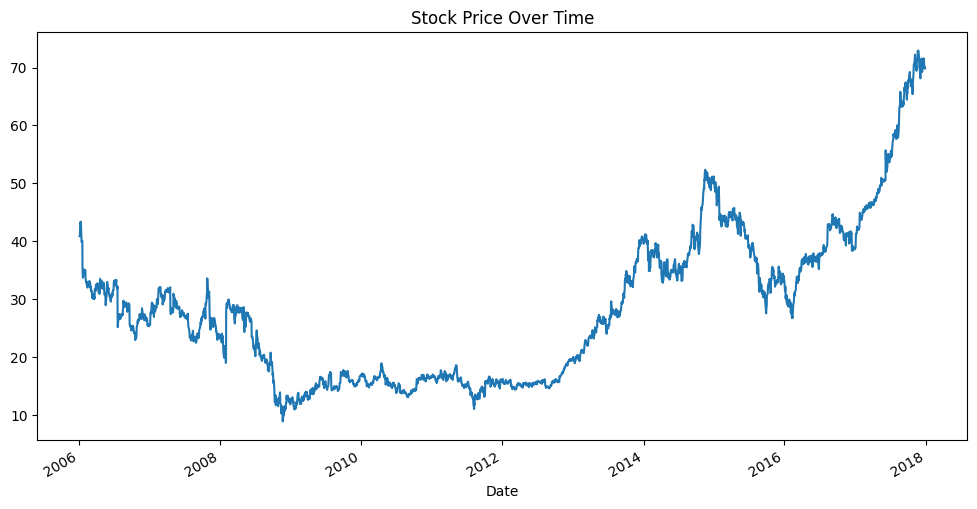

In [ ]:
# EDA
plt.figure(figsize=(12,6))
df['Close'].plot(title='Stock Price Over Time')
plt.show()


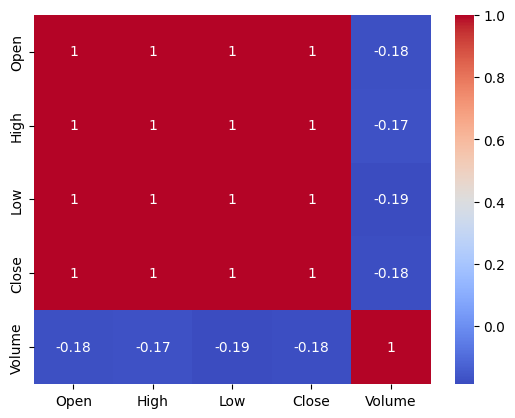

In [ ]:

df_numeric = df.drop(columns=['Name'])
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.show()


In [ ]:
# Feature Engineering
df['Return'] = df['Close'].pct_change()
df['Lag_1'] = df['Close'].shift(1)
df['Lag_5'] = df['Close'].shift(5)
df['Rolling_Mean_5'] = df['Close'].rolling(window=5).mean()
df['Rolling_Std_5'] = df['Close'].rolling(window=5).std()
df = df.dropna()

In [ ]:
# Splitting Data
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

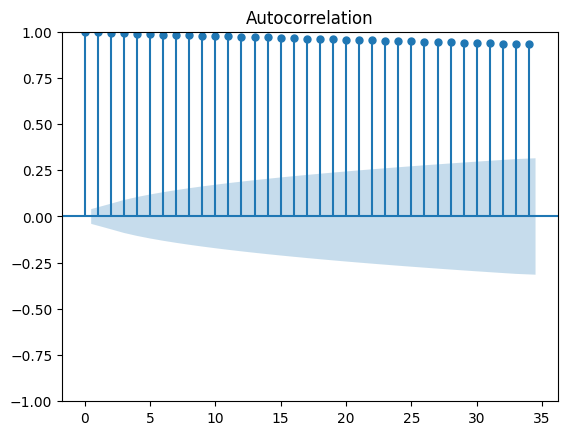

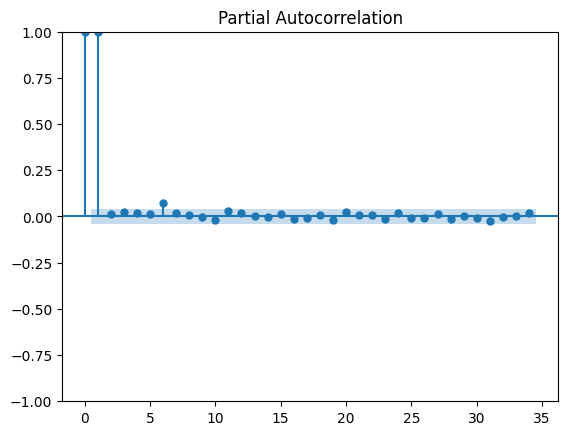

In [ ]:
# ARIMA Model
plot_acf(train['Close'])
plot_pacf(train['Close'])
plt.show()

In [ ]:
print(train.index)


DatetimeIndex(['2006-01-10', '2006-01-11', '2006-01-12', '2006-01-13',
               '2006-01-17', '2006-01-18', '2006-01-19', '2006-01-20',
               '2006-01-23', '2006-01-24',
               ...
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
               '2015-08-07', '2015-08-10'],
              dtype='datetime64[ns]', name='Date', length=2411, freq=None)


In [ ]:
train.index = pd.to_datetime(train.index)  # Ensure it's a DatetimeIndex
train = train.asfreq('D')  # Set frequency to daily ('D'), or adjust based on your data


In [ ]:
# ARIMA Model
p, d, q = 2, 1, 1  # New optimized values
arima_model = ARIMA(train['Close'], order=(p, d, q))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

In [ ]:
# ARIMA Evaluation
rmse_arima = np.sqrt(mean_squared_error(test['Close'], predictions_arima))
mae_arima = mean_absolute_error(test['Close'], predictions_arima)
mape_arima = mean_absolute_percentage_error(test['Close'], predictions_arima)

In [ ]:
df = df.dropna()
train_gbr, test_gbr = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
# GBR Model
features = ['Lag_1', 'Lag_2', 'Rolling_Mean_7', 'Rolling_Std_7', 'EMA_10', 'Momentum']
gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01)
gbr.fit(train_gbr[features], train_gbr['Close'])
gbr_pred = gbr.predict(test_gbr[features])

In [ ]:

# Reindex GBR predictions to match the ARIMA test index
gbr_pred = pd.Series(gbr_pred, index=test_gbr.index)

In [ ]:
# Hybrid Model Prediction (ARIMA + GBR Residuals)
hybrid_pred = arima_pred + gbr_pred

In [ ]:
gbr = GradientBoostingRegressor()
params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
gbr_cv = GridSearchCV(gbr, param_grid=params, cv=3)
gbr_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]})

In [ ]:
y_pred_gbr = gbr_cv.best_estimator_.predict(X_test)

In [ ]:
# Gradient Boosting Evaluation
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mape_gbr = mean_absolute_percentage_error(y_test, y_pred_gbr)

In [ ]:
# Comparison
# Create a formatted output with headers and aligned columns
print("="*50)
print(f"{'Model':<20}{'RMSE':<15}{'MAE':<15}{'MAPE':<15}")
print("="*50)
print(f"{'ARIMA':<20}{rmse_arima:<15.4f}{mae_arima:<15.4f}{mape_arima:<15.4f}")
print(f"{'Gradient Boosting':<20}{rmse_gbr:<15.4f}{mae_gbr:<15.4f}{mape_gbr:<15.4f}")
print("="*50)


Model               RMSE           MAE            MAPE           
ARIMA               14.4941        10.2241        0.1963         
Gradient Boosting   6.7354         3.3035         0.0540         


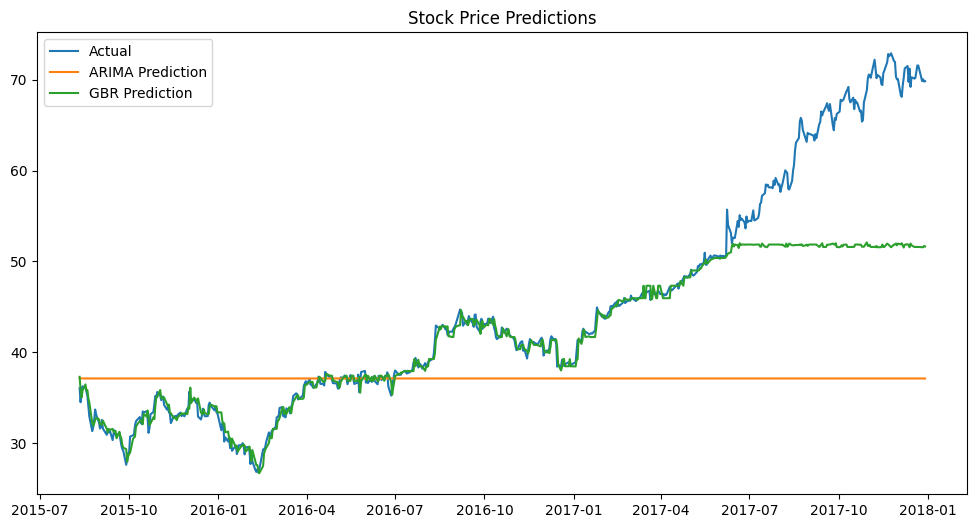

In [ ]:
# Visualization
plt.figure(figsize=(12,6))
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, predictions_arima, label='ARIMA Prediction')
plt.plot(test.index, y_pred_gbr, label='GBR Prediction')
plt.legend()
plt.title('Stock Price Predictions')
plt.show()

In [ ]:
import pickle

# Save ARIMA and GBR models
with open("arima_gbr_model.pkl", "wb") as f:
    pickle.dump({"arima": arima_fit, "gbr": gbr}, f)

print("Models saved successfully!")


Models saved successfully!


In [ ]:
import pickle
import pandas as pd

# Load the saved ARIMA + GBR models
with open("arima_gbr_model.pkl", "rb") as f:
    models = pickle.load(f)

arima_fit = models["arima"]
gbr = models["gbr"]

# Load your dataset (Ensure preprocessing matches training data)
df = pd.read_csv("stock_data.csv", parse_dates=["Date"], index_col="Date")

# Feature Engineering for Gradient Boosting
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)
df['Rolling_Mean_7'] = df['Close'].rolling(window=7).mean()
df['Rolling_Std_7'] = df['Close'].rolling(window=7).std()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['Momentum'] = df['Close'].pct_change(periods=5)

df = df.dropna()  # Drop NaN values after feature creation
test = df.iloc[int(len(df) * 0.8):]  # Use last 20% as test set

# **🔹 Step 2: Make Predictions**
# ARIMA Forecast
arima_pred = arima_fit.forecast(steps=len(test))

# GBR Residual Correction
gbr_pred = gbr.predict(test[['Lag_1', 'Lag_2', 'Rolling_Mean_7', 'Rolling_Std_7', 'EMA_10', 'Momentum']])

# **Hybrid Model Prediction (ARIMA + GBR Residuals)**
hybrid_pred = arima_pred + gbr_pred

# **🔹 Step 3: Save Hybrid Predictions to CSV**
test["Hybrid_Prediction"] = hybrid_pred
test.to_csv("hybrid_predictions.csv")

# Print some predictions
print(test[["Close", "Hybrid_Prediction"]].head())

print("Hybrid model predictions saved successfully! 🎯")


            Close  Hybrid_Prediction
Date                                
2015-08-11  36.03          73.457059
2015-08-12  34.49          72.407943
2015-08-13  35.93          72.166575
2015-08-14  36.24          72.888981
2015-08-17  36.10          73.021670
Hybrid model predictions saved successfully! 🎯


<ipython-input-48-883a32102e2a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Hybrid_Prediction"] = hybrid_pred


In [ ]:
import pickle

# Load the ARIMA and GBR models
with open("arima_gbr_model.pkl", "rb") as f:
    models = pickle.load(f)

# Access the ARIMA and GBR models
arima_loaded = models['arima']
gbr_loaded = models['gbr']

print("Models loaded successfully!")

# Example usage with the loaded models:
# To make predictions using the ARIMA model
arima_pred_loaded = arima_loaded.forecast(steps=len(test))

# To make predictions using the GBR model
gbr_pred_loaded = gbr_loaded.predict(test_gbr[features])

# Now you can continue with your hybrid prediction or other analysis


Models loaded successfully!
